# Linear Unmixing of Spectral Fluorescence Microscopy Data

In this notebook we perform linear unmixing on spectral data from Fluorescence Microscopy.

In this case, for a given pixel, we suppose to have a set of intensity measurements at different wavelengths, e.g., $y = [y(\lambda_1),y(\lambda_2),\dots,y(\lambda_n)]$, with $n=32$ for instance. For each one of these spectral bands $\lambda_i$, with $i=1,\dots,n$, and for each fluorophore $f$, with $f=1,\dots,m$, we assume the reference spectra $R_f=[R_f(\lambda_1), R_f(\lambda_2), \dots, R_f(\lambda_n)]$ to be known. 

### 1. Data Preparation

Load mixed image & metadata:

In [20]:
import os
import json
import tifffile as tiff

DATA_DIR = '/group/jug/federico/microsim/sim_spectral_data/240717_v0'
load_mip = False

In [21]:
mixed_opt_img = tiff.imread(
    os.path.join(
        DATA_DIR, 
        f"{"mips" if load_mip else "imgs"}/optical_mixed{"_mip" if load_mip else ""}.tif"
    )
)
print("Loaded optical mixed image!")

Loaded optical mixed image!


In [22]:
mixed_digital_img = tiff.imread(
    os.path.join(
        DATA_DIR, 
        f"{"mips" if load_mip else "imgs"}/digital_mixed{"_mip" if load_mip else ""}.tif"
    )
)
print("Loaded digital mixed image!")

Loaded digital mixed image!


In [23]:
with open(os.path.join(DATA_DIR, "sim_coords.json"), "r") as f:
    coords_metadata = json.load(f)

try:    
    with open(os.path.join(DATA_DIR, "sim_metadata.json"), "r") as f:
        sim_metadata = json.load(f)
except FileNotFoundError as e:
    print("Metadata file not found!")
    sim_metadata = None

In [24]:
# Load GT
gt_img = tiff.imread(os.path.join(DATA_DIR, "ground_truth_img.tif"))

In [25]:
from utils import coarsen_img

try:
    downscaling = int(sim_metadata["downscale"])
except:
    downscaling = 2
gt_img_downsc = coarsen_img(gt_img, downscaling)

In [26]:
mixed_opt_img.shape, mixed_digital_img.shape, gt_img.shape, gt_img_downsc.shape, coords_metadata.keys(), sim_metadata.keys()

((32, 52, 512, 512),
 (32, 26, 256, 256),
 (3, 52, 512, 512),
 (3, 26, 256, 256),
 dict_keys(['x_coords', 'y_coords', 'z_coords', 'w_bins']),
 dict_keys(['fluorophores', 'light_powers', 'downscale', 'detect_exposure_ms', 'detect_quantum_eff', 'min_max_wavelength']))

In [27]:
for k, v in sim_metadata.items():
    print(f"{k}: {v}")

fluorophores: ['mTurquoise', 'EGFP', 'EYFP']
light_powers: [3.0, 1.0, 1.0]
downscale: 2
detect_exposure_ms: 10
detect_quantum_eff: 0.5
min_max_wavelength: [460, 550]


Compute *PSNR* for the Digital Image w.r.t. the downscaled optical image

In [28]:
try:
    downscaling = int(sim_metadata["downscale"])
except:
    downscaling = 2
mixed_opt_img_downsc = coarsen_img(mixed_opt_img, downscaling)

In [29]:
from utils.metrics import SpectralPSNR

dig_psnr = SpectralPSNR(gt=mixed_opt_img_downsc, pred=mixed_digital_img, range_inv=True)
print(f"PSNR digital wrt optical: {dig_psnr:.2f}")

PSNR digital wrt optical: 17.73


Get reference spectra from `FPBase` using `microsim` API:

In [30]:
from microsim.schema.sample import Fluorophore

def fetch_FPs(fp_names: list[str]) -> list[Fluorophore]:
    return [Fluorophore.from_fpbase(name=fp_name) for fp_name in fp_names]

fp1, fp2, fp3 = fetch_FPs(sim_metadata["fluorophores"])

In [31]:
import xarray as xr

fp1_em = xr.DataArray(fp1.emission_spectrum.intensity, coords=[fp1.emission_spectrum.wavelength.magnitude], dims=["w"])
fp2_em = xr.DataArray(fp2.emission_spectrum.intensity, coords=[fp2.emission_spectrum.wavelength.magnitude], dims=["w"])
fp3_em = xr.DataArray(fp3.emission_spectrum.intensity, coords=[fp3.emission_spectrum.wavelength.magnitude], dims=["w"])

In [32]:
# Bin the emission spectra to the same wavelength range as the data
em_bins = coords_metadata["w_bins"]
sbins = sorted(set([bins[0] for bins in em_bins] + [em_bins[-1][1]]))

fp1_em_binned = fp1_em.groupby_bins(fp1_em["w"], sbins).sum()
fp2_em_binned = fp2_em.groupby_bins(fp2_em["w"], sbins).sum()
fp3_em_binned = fp3_em.groupby_bins(fp3_em["w"], sbins).sum()

In [33]:
# Replace nan values with 0
fp1_em_binned = fp1_em_binned.fillna(0)
fp2_em_binned = fp2_em_binned.fillna(0)
fp3_em_binned = fp3_em_binned.fillna(0)

**OBSERVATION**
The mixed image is a 16bit image (range: 0-6.5e4), whereas the intensity of fluorophores emission spectra ranges in 0-1 before the binning.

Intuitively, intensity ranges should be the same. However does this really matter?

In my understanding, the answer is NO. Let's see why:

- Suppose the case of 0-1 range normalization. In that case, normalization is obtained by simply dividing each pixel's intensity by the maximum intensity in the image. In other terms we basically divide by a scalar. Therefore, supposing that we normalize in this way both the mixed image and the reference spectra, the linear system becomes:

\begin{equation}
\frac{1}{k_I}y = \frac{1}{k_R}\mathbf{R}c
\end{equation}

where $k_I$ and $k_R$ are scalar. Therefore the solution of this system is the same up to some multiplicative constants.

Therefore, we can normalize everything in the range 0-1 so that quantities are in the same scale.

In [34]:
mixed_opt_img = (mixed_opt_img - mixed_opt_img.min()) / (mixed_opt_img.max() - mixed_opt_img.min())
fp1_em_binned = (fp1_em_binned - fp1_em_binned.min()) / (fp1_em_binned.max()- fp1_em_binned.min())
fp2_em_binned = (fp2_em_binned - fp2_em_binned.min()) / (fp2_em_binned.max()- fp2_em_binned.min())
fp3_em_binned = (fp3_em_binned - fp3_em_binned.min()) / (fp3_em_binned.max()- fp3_em_binned.min())

Prepare the matrix R of reference fluorophore intensities:

In [35]:
import numpy as np

fp_ref_matrix = np.stack([fp1_em_binned.values, fp2_em_binned.values, fp3_em_binned.values], axis=1)

### 2. Compute the LS solution

In [36]:
from methods.LeastSquares import lstsq_fit

# Solving for digital image
fp_conc_img = lstsq_fit(mixed_digital_img, fp_ref_matrix)

Solving LS on z slice:   0%|          | 0/26 [00:00<?, ?it/s]

Solving LS on z slice: 100%|██████████| 26/26 [00:50<00:00,  1.93s/it]


### 3. Visualizing results

In [45]:
# Load GT (unmixed optical image)
fluor1_gt_img = tiff.imread(os.path.join(DATA_DIR, "imgs/optical_fluor1_gt.tif"))
fluor2_gt_img = tiff.imread(os.path.join(DATA_DIR, "imgs/optical_fluor2_gt.tif"))
fluor3_gt_img = tiff.imread(os.path.join(DATA_DIR, "imgs/optical_fluor3_gt.tif"))

# Add channel dimension
fluor1_gt_img = fluor1_gt_img[np.newaxis, ...]
fluor2_gt_img = fluor2_gt_img[np.newaxis, ...]
fluor3_gt_img = fluor3_gt_img[np.newaxis, ...]

In [46]:
# Get downsclaed GT
try:
    downscaling = int(sim_metadata["downscale"])
except:
    downscaling = 2
fluor1_gt_img_downsc = coarsen_img(fluor1_gt_img, downscaling)
fluor2_gt_img_downsc = coarsen_img(fluor2_gt_img, downscaling)
fluor3_gt_img_downsc = coarsen_img(fluor3_gt_img, downscaling)

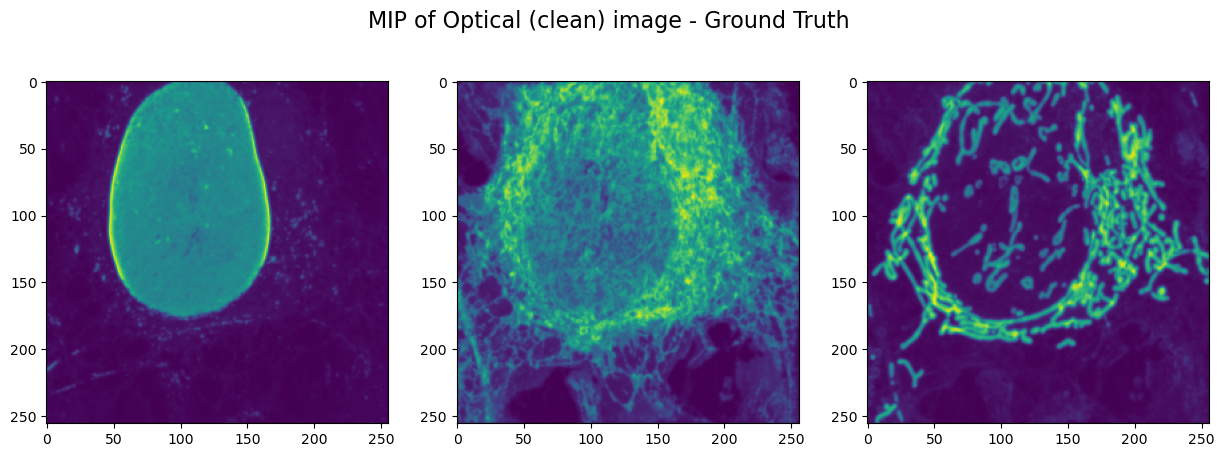

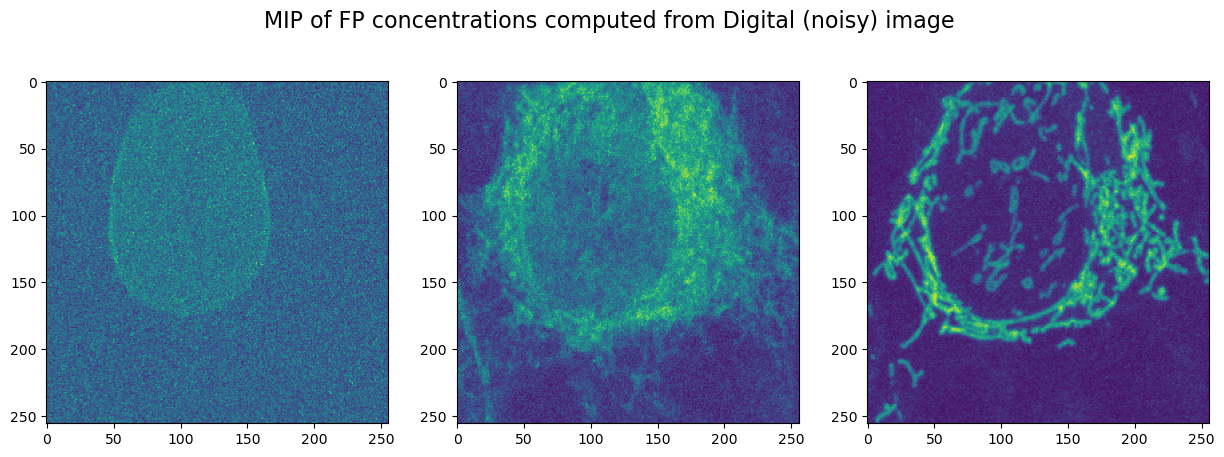

In [49]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("MIP of Optical (clean) image - Ground Truth", fontsize=16)
ax[0].imshow(fluor1_gt_img_downsc.max(axis=1)[0, ...])
ax[1].imshow(fluor2_gt_img_downsc.max(axis=1)[0, ...])
ax[2].imshow(fluor3_gt_img_downsc.max(axis=1)[0, ...])


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("MIP of FP concentrations computed from Digital (noisy) image", fontsize=16)
if load_mip:
    ax[0].imshow(fp_conc_img[0, :, :])
    ax[1].imshow(fp_conc_img[1, :, :])
    ax[2].imshow(fp_conc_img[2, :, :])
else:
    ax[0].imshow(fp_conc_img.max(axis=1)[0, :, :])
    ax[1].imshow(fp_conc_img.max(axis=1)[1, :, :])
    ax[2].imshow(fp_conc_img.max(axis=1)[2, :, :])

### 4. Evaluation

Compute error with respect to ground truth images for each flurophore.

The ground truth images are `(Z, Y, X)` arrays, which correspond to the clean image that we would get from one FP alone.

Observe that the solution of the linear unmixing problem expresses **concentrations** of FPs, whereas the GT microscope images express values as intensities. <br>
A way to compare these quantities is by using the **Range Invariant PSNR**, which is independent of the scale of the involved quantities.   

Here, we compute the overall error for each FP as the Range Invariant PSNR and visualize it:

PSNR: 18.402396, 19.649051, 24.625200


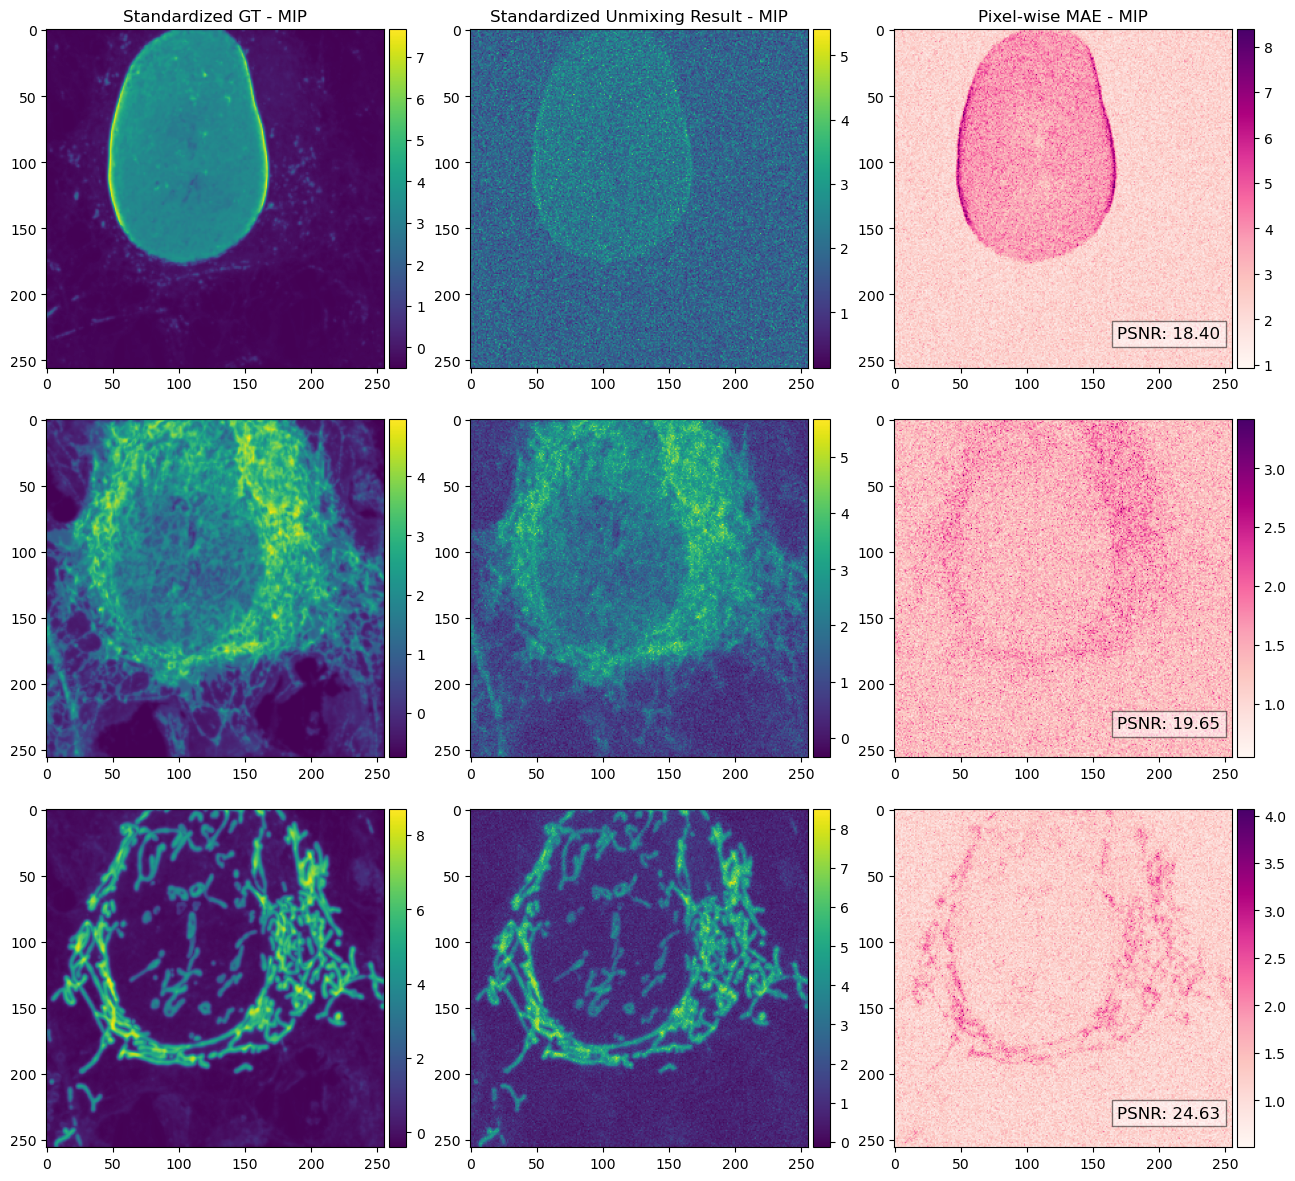

In [63]:
from utils.plots import plot_unmixed_vs_gt

plot_unmixed_vs_gt(
    gt_img=[fluor1_gt_img_downsc, fluor2_gt_img_downsc, fluor3_gt_img_downsc],
    unmixed_img=fp_conc_img,
)